In [31]:
import requests
import requests_cache
import lxml.html as lx
import re
import time
import pandas as pd
import numpy as np

requests_cache.install_cache("project")

Goals:
1. Use API
2. Webscraping (XPath and Beautiful Soup)
3. Natural Language Processing (Finding good estimators for things)
4. Visualization
5. Analysis

# Preface (Main things)

https://www.imf.org/external/datamapper/PCPIPCH@WEO/OEMDC/ADVEC/WEOWORLD

In [32]:
endpoint = "https://www.imf.org/external/datamapper/api/v1/indicators"

response = requests.get(endpoint)
time.sleep(0.05)

if response.status_code == 200:
    data = response.json()
    
    for indicator, details in data['indicators'].items():
        print("Indicator:", indicator)
        print("Label:", details['label'])
        print("Description:", details['description'])
        print("Source:", details['source'])
        print("Unit:", details['unit'])
        print("Dataset:", details['dataset'])
        print()
else:
    print("Failed to retrieve data. Status code:", response.status_code)

Indicator: NGDP_RPCH
Label: Real GDP growth
Description: Gross domestic product is the most commonly used single measure of a country's overall economic activity. It represents the total value at constant prices of final goods and services produced within a country during a specified time period, such as one year.
Source: World Economic Outlook (October 2023)
Unit: Annual percent change
Dataset: WEO

Indicator: NGDPD
Label: GDP, current prices
Description: Gross domestic product is the most commonly used single measure of a country's overall economic activity. It represents the total value at current prices of final goods and services produced within a country during a specified time period, such as one year.
Source: World Economic Outlook (October 2023)
Unit: Billions of U.S. dollars
Dataset: WEO

Indicator: NGDPDPC
Label: GDP per capita, current prices

Description: Gross domestic product is the most commonly used single measure of a country's overall economic activity. It represents

This gives us a list of parameters to find data for

# API Function

In [33]:
import requests
import time

def retrieve_data(data_values, year=""):
    base_endpoint = "https://www.imf.org/external/datamapper/api/v1/"

    result = {}  

    for category in data_values:
        # Append the category to the base endpoint
        endpoint = base_endpoint + category + "?periods=" + year
        
        response = requests.get(endpoint)
        time.sleep(0.05)

        if response.status_code == 200:
            data = response.json()
            
            result[category] = data["values"][data_values[0]]              
        else:
            print(f"Failed to retrieve data for category {category}. Status code:", response.status_code)
    
    return result

This is the API, we append stuff like "PPPGDP" to the end of the base link to retrieve information

# Global Happiness Index

https://worldpopulationreview.com/country-rankings/happiest-countries-in-the-world

In [34]:
tabs = pd.read_html("https://worldpopulationreview.com/country-rankings/happiest-countries-in-the-world")
tabs[1]

,Country,World Happiness Report Rankings 2023,World Happiness Report Score 2023,World Happiness Report Rankings 2022,World Happiness Report Score 2022,Rankings Change 2023-2022,Report Score Change 2023-2022
0,Finland,1.0,7.80,1.0,7.82,NaN,-0.02
1,Denmark,2.0,7.59,2.0,7.64,NaN,-0.05
2,Iceland,3.0,7.53,3.0,7.56,NaN,-0.03
3,Israel,4.0,7.47,9.0,7.36,-5.0,0.11
4,Netherlands,5.0,7.40,5.0,7.42,NaN,-0.01
...,...,...,...,...,...,...,...
140,Libya,NaN,NaN,86.0,5.33,NaN,NaN
141,Turkmenistan,NaN,NaN,78.0,5.47,NaN,NaN
142,Kuwait,NaN,NaN,50.0,6.11,NaN,NaN
143,Lesotho,NaN,NaN,141.0,3.51,NaN,NaN


Web-scraped data table from the website

In [35]:
iso_table = pd.read_html("https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes")
df = iso_table[0]
new_column_names = ['Country', 'Official Name', 'Sovereignty', "2 digit ISO", "ISO", "1", "2", "3"]
df.columns = new_column_names
df = df.drop(columns=['2 digit ISO', "1", "2", "3"])
df = df[df['ISO'].str.len() == 3]
df[['Country', 'Sovereignty']] = df[['Country', 'Sovereignty']].applymap(lambda x: re.sub(r'\[.*?\]|\(.*?\)', '', x).strip())
df = df[df['Sovereignty'].isin(['UN member', 'UN observer', 'Disputed', 'China'])]

country_iso_dict = dict(zip(df['Country'], df['ISO']))

full_country_iso_dict = dict(zip(df['Official Name'], df['ISO']))

df

,Country,Official Name,Sovereignty,ISO
0,Afghanistan,The Islamic Republic of Afghanistan,UN member,AFG
2,Albania,The Republic of Albania,UN member,ALB
3,Algeria,The People's Democratic Republic of Algeria,UN member,DZA
5,Andorra,The Principality of Andorra,UN member,AND
6,Angola,The Republic of Angola,UN member,AGO
...,...,...,...,...
263,Viet Nam,The Socialist Republic of Viet Nam,UN member,VNM
267,Western Sahara,The Sahrawi Arab Democratic Republic,Disputed,ESH
268,Yemen,The Republic of Yemen,UN member,YEM
269,Zambia,The Republic of Zambia,UN member,ZMB


Retrieve data to create a country to ISO converter

In [36]:
def country_to_iso(name):
    if name in country_iso_dict:
        return country_iso_dict[name]
    else:
        # Find if the entire phrase is a substring of any key in the dictionary
        matches = [key for key in country_iso_dict.keys() if name.lower() in key.lower()]
        matches_2 = [key for key in full_country_iso_dict.keys() if (name.lower() in key.lower()) and (
            'congo' not in key.lower())]
        if matches:
            return country_iso_dict[matches[0]]
        elif matches_2:
            return full_country_iso_dict[matches_2[0]]
        elif name in manual_iso:
            return manual_iso[name] 
        else:
            return name

manual_iso = {
    'South Korea': 'KOR',
    'Vietnam': 'VNM',
    'Laos': 'LAO',
    'Ivory Coast': 'CIV',
    'Turkey': 'TUR',
    'Trkiye': 'TUR',    
    'Republic of the Congo': 'COG',
    'Democratic Republic of the Congo': 'COD',
    'DR Congo': 'COD',
    'Cte dIvoire': 'CIV'
}

country_iso = []
for i in tabs[1]["Country"].values:
    country_name = i
    country_iso.append(country_to_iso(country_name))
    
tabs[1]["Country ISO"] = country_iso

iso_happy_dict = {key: value for key, value in zip(tabs[1]["Country ISO"], tabs[1]["World Happiness Report Score 2023"])}
iso_happy_dict

{'FIN': 7.8,
 'DNK': 7.59,
 'ISL': 7.53,
 'ISR': 7.47,
 'NLD': 7.4,
 'SWE': 7.39,
 'NOR': 7.32,
 'CHE': 7.24,
 'LUX': 7.23,
 'NZL': 7.12,
 'AUT': 7.1,
 'AUS': 7.09,
 'CAN': 6.96,
 'IRL': 6.91,
 'USA': 6.89,
 'DEU': 6.89,
 'BEL': 6.86,
 'CZE': 6.84,
 'GBR': 6.8,
 'LTU': 6.76,
 'FRA': 6.66,
 'SVN': 6.65,
 'CRI': 6.61,
 'ROU': 6.59,
 'SGP': 6.59,
 'ARE': 6.57,
 'TWN': 6.54,
 'URY': 6.49,
 'SVK': 6.47,
 'SAU': 6.46,
 'EST': 6.46,
 'ESP': 6.44,
 'ITA': 6.41,
 'CHL': 6.33,
 'MEX': 6.33,
 'MLT': 6.3,
 'PAN': 6.26,
 'POL': 6.26,
 'NIC': 6.26,
 'LVA': 6.21,
 'BHR': 6.17,
 'GTM': 6.15,
 'KAZ': 6.14,
 'SRB': 6.14,
 'CYP': 6.13,
 'JPN': 6.13,
 'HRV': 6.13,
 'BRA': 6.13,
 'SLV': 6.12,
 'HUN': 6.04,
 'ARG': 6.02,
 'HND': 6.02,
 'UZB': 6.01,
 'MYS': 6.01,
 'PRT': 5.97,
 'KOR': 5.95,
 'GRC': 5.93,
 'MUS': 5.9,
 'THA': 5.84,
 'MNG': 5.84,
 'KGZ': 5.83,
 'MDA': 5.82,
 'CHN': 5.82,
 'VNM': 5.76,
 'PRY': 5.74,
 'MNE': 5.72,
 'JAM': 5.7,
 'BOL': 5.68,
 'RUS': 5.66,
 'BIH': 5.63,
 'COL': 5.63,
 'DOM': 5.57,

Problems during coding:
Scraped table and had to clean it up and show only relevant information

Made the Country:ISO dictionary but some countries can't seem to be found (like United States doesn't work because you need United States of America

To remedy this, I tried to make it so that if the Country is a substring of another key in the dictionary, it will use that correspoding ISO which would fix "United Kingdom" because it is a substring of "United Kingdom of Great Britain and Northern Ireland (the)".

Now theres a new problem, the leftover keys could be assigned to the wrong ISO as the country could be a substring of another country (Like United States is also a substring of "United States Minor Outlying Islands (the)" whose ISO is "UMI" instead of "USA")

To fix this, I filtered the data to only show UN Members, which is a column in the data frame as to get rid of territories owned by countries.

New problem, now Taiwan, Palestine, Hong Kong doesn't work as they are labeled as Disputed, UN observers, etc.. so I'll have to include those in the filter

I also decided to create a new dictionary as the data frame provides the country name and their offical full state name (like how "China" is actually "The People's Republic of China" so that if the leftover keys are also a substring of their offical state name, it can get its correspodning ISO which fixed things like "Czech Republic" as its not a substring of Czechia but it is a substring of "The Czech Republic"

Struggled with "Democratic Republic of the Congo" and "The Republic of the Congo" as "Congo" is a subscript of both the normal names and the offical names. Had no choice but to simply exclude that result from the filter.

Finally, since there are simply no other string or filter methods to generally get Turkey into "TUR" as both the name and offical name is/contains "Türkiye" which is not filterable, I just had to gather these cases and manually convert them.

# GDP per capita vs Happiness Index

In [7]:
def extract_iso_values(original_dict):
    # New dictionary to store country code and GDP values
    new_dict = {}

    # Get the first key from the retrieved data dictionary
    first_key = next(iter(original_dict), None)

    # Check if the first key is not None
    if first_key:
        # Iterate over the values corresponding to the first key
        for country_code, gdp_data in original_dict[first_key].items():
            # Extract GDP value for the country
            gdp_value = list(gdp_data.values())[0] if gdp_data else None
            # Add country code and GDP value to the new dictionary
            new_dict[country_code] = gdp_value

    return new_dict

In [27]:
gdp_p_capita = retrieve_data(["NGDPDPC"], "2023")
gdp_p_capita

{'NGDPDPC': {'ABW': {'2023': 35717.948},
  'ADVEC': {'2023': 55920.76},
  'AFQ': {'2023': 2044.409},
  'AGO': {'2023': 2550.001},
  'ALB': {'2023': 8057.49},
  'AND': {'2023': 44107.317},
  'APQ': {'2023': 8388.461},
  'ARE': {'2023': 50602.325},
  'ARG': {'2023': 13297.425},
  'ARM': {'2023': 8283.119},
  'AS5': {'2023': 6597.204},
  'ATG': {'2023': 19068.279},
  'AUS': {'2023': 63487.049},
  'AUT': {'2023': 58013.273},
  'AZE': {'2023': 7529.695},
  'AZQ': {'2023': 60969.72},
  'BDI': {'2023': 245.811},
  'BEL': {'2023': 53656.833},
  'BEN': {'2023': 1449.112},
  'BFA': {'2023': 888.029},
  'BGD': {'2023': 2621.288},
  'BGR': {'2023': 16086.569},
  'BHR': {'2023': 28464.173},
  'BHS': {'2023': 34370.86},
  'BIH': {'2023': 7778.298},
  'BLR': {'2023': 7477.293},
  'BLZ': {'2023': 7141.538},
  'BOL': {'2023': 3857.843},
  'BRA': {'2023': 10412.997},
  'BRB': {'2023': 21442.447},
  'BRN': {'2023': 34383.527},
  'BTN': {'2023': 3500.486},
  'BWA': {'2023': 7758.371},
  'CAF': {'2023': 53

This function will take in a dictionary, and return a dictionary where the key is the country ISO and value is the corresponding data.

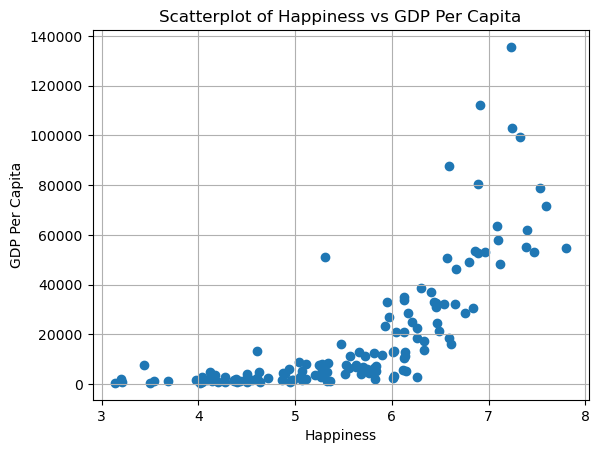

In [8]:
import matplotlib.pyplot as plt

gdp_p_capita = retrieve_data(["NGDPDPC"], "2023")
iso_gdp_p_capita = extract_iso_values(gdp_p_capita)

dict_A = iso_happy_dict
dict_B = iso_gdp_p_capita

x_values = []
y_values = []

# Iterate over keys in dict_A
for key in dict_A:
    if key in dict_B:
        # If key exists in dict_B, append values to lists
        x_values.append(dict_A[key])
        y_values.append(dict_B[key])

plt.scatter(x_values, y_values)
plt.xlabel('Happiness')
plt.ylabel('GDP Per Capita')
plt.title('Scatterplot of Happiness vs GDP Per Capita')
plt.grid(True)
plt.show()

This is a graph of happiness rating vs gdp per capita

# Change in GDP per capita vs Happiness Index

In [9]:
gdp_capita_2023 = retrieve_data(["NGDPDPC"], "2023")
iso_gdp_cap_2023 = extract_iso_values(gdp_capita_2023)

gdp_capita_2022 = retrieve_data(["NGDPDPC"], "2013")
iso_gdp_cap_2013 = extract_iso_values(gdp_capita_2022)

def subtract_dicts(dict1, dict2):
    result = {}
    for key in dict1.keys():
        if key in dict2:
            result[key] = dict1[key] - dict2[key]
        else:
            # Handle case where key is only in dict1 or dict2
            result[key] = dict1[key]
    return result

result = subtract_dicts(iso_gdp_cap_2023, iso_gdp_cap_2013)
result

{'ABW': 9904.424999999996,
 'ADVEC': 11088.516000000003,
 'AFQ': -300.942,
 'AGO': -2678.51,
 'ALB': 3641.8899999999994,
 'AND': -1522.877999999997,
 'APQ': 2243.1749999999993,
 'ARE': 4394.877,
 'ARG': -1191.4040000000005,
 'ARM': 4551.084000000001,
 'AS5': 1587.2119999999995,
 'ATG': 5653.376999999999,
 'AUS': -1713.7739999999976,
 'AUT': 7265.889000000003,
 'AZE': -396.39900000000034,
 'AZQ': -525.7929999999978,
 'BDI': -9.507999999999981,
 'BEL': 6808.220999999998,
 'BEN': 234.79899999999998,
 'BFA': 125.71399999999994,
 'BGD': 1445.128,
 'BGR': 8383.786,
 'BHR': 2498.8619999999974,
 'BHS': 5674.975000000002,
 'BIH': 2636.7259999999997,
 'BLR': -518.4400000000005,
 'BLZ': 1338.1539999999995,
 'BOL': 919.422,
 'BRA': -2339.258,
 'BRB': 4886.3369999999995,
 'BRN': -10481.716999999997,
 'BTN': 890.7280000000001,
 'BWA': 1321.768,
 'CAF': 158.93600000000004,
 'CAN': 538.3709999999992,
 'CAQ': 1708.0679999999993,
 'CBQ': 1258.3249999999998,
 'CHE': 14987.027000000002,
 'CHL': 1513.36100

This code finds difference between GDP per capita in 2023 vs 2013.

In [10]:
def extract_corresponding_values_and_create_dict(dict_A, dict_B):
    x_values = []
    y_values = []

    for key in dict_A:
        if key in dict_B:
            x_values.append(dict_A[key])
            y_values.append(dict_B[key])

    new_dict = dict(zip(y_values, x_values))
    return new_dict

result_dict = extract_corresponding_values_and_create_dict(iso_happy_dict, result)

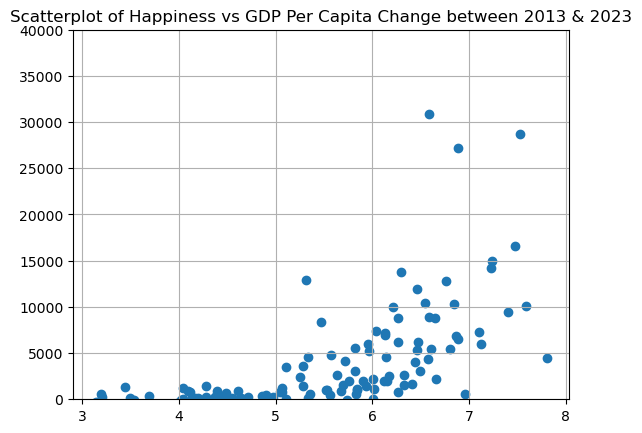

In [11]:
plt.scatter(list(result_dict.values()), list(result_dict.keys()))
plt.grid(True)
plt.title('Scatterplot of Happiness vs GDP Per Capita Change between 2013 & 2023')
plt.ylim(0, 40000)
plt.show()

This graph tells is that typically, in a 10 year period, when a country's GDP per capita grows, the happiness of the country also grows

# Graph of Happiness vs Inflation Rate

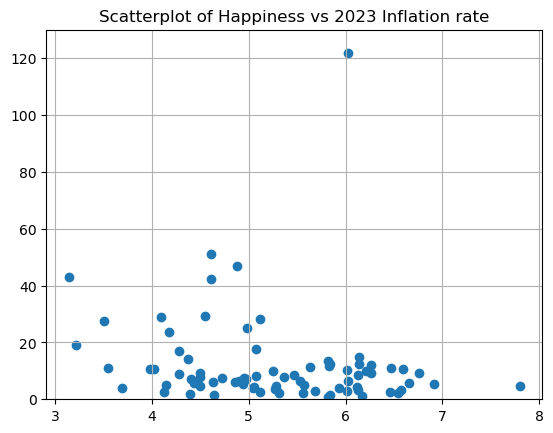

In [12]:
inflation_rate_2023 = retrieve_data(["PCPIPCH"], "2023")
iso_inflation_rate_2023 = extract_iso_values(inflation_rate_2023)
iso_inflation_rate_2023

infla_dict = extract_corresponding_values_and_create_dict(iso_happy_dict, iso_inflation_rate_2023)

plt.scatter(list(infla_dict.values()), list(infla_dict.keys()))
plt.grid(True)
plt.title('Scatterplot of Happiness vs 2023 Inflation rate')
plt.ylim(0, 130)  # Setting the limit for the y-axis
plt.show()

Graph of 2023 Happiness vs Inflation Rate. 2 outliers are removed to better depict the data.

# Global Corruption Score vs Happiness
https://www.worldeconomics.com/Indicator-Data/Corruption/Corruption-Perceptions-Index.aspx

In [13]:
corruption_table = pd.read_html("https://www.worldeconomics.com/Indicator-Data/Corruption/Corruption-Perceptions-Index.aspx")
corruption_table[0]

,Corruption Perceptions,World Economics Corruption Index (0-100),World Economics Corruption Grade A-E
0,Denmark,100.0,A
1,Finland,96.7,A
2,New Zealand,94.4,A
3,Norway,93.3,A
4,Singapore,92.2,A
...,...,...,...
147,Libya,20.0,E
148,Turkmenistan,20.0,E
149,Haiti,18.9,E
150,Nicaragua,18.9,E


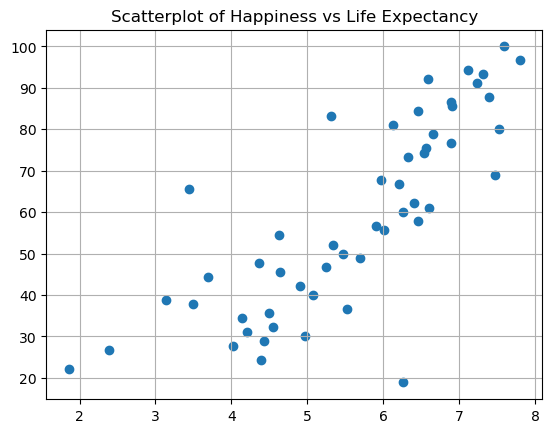

In [14]:
country_iso = []
for i in corruption_table[0]["Corruption Perceptions"].values:
    country_name = i
    country_iso.append(country_to_iso(country_name))
    
country_iso_dict_corr = {key: value for key, value in zip(country_iso, corruption_table[0]["World Economics Corruption Index (0-100)"])}

corr_dict = extract_corresponding_values_and_create_dict(iso_happy_dict, country_iso_dict_corr)

plt.scatter(list(corr_dict.values()), list(corr_dict.keys()))
plt.grid(True)
plt.title('Scatterplot of Happiness vs Life Expectancy')
plt.show()


Might exclude this one, only has like 60 data points

# Life Expectancy vs Happiness
https://www.worldometers.info/demographics/life-expectancy/

In [15]:
life_expectantcy_table = pd.read_html("https://www.worldometers.info/demographics/life-expectancy/")
life_expectantcy_table[0]

,#,Country,Life Expectancy (both sexes),Females Life Expectancy,Males Life Expectancy
0,1,Hong Kong,85.83,88.66,83.00
1,2,Macao,85.51,88.11,82.88
2,3,Japan,84.95,87.97,81.91
3,4,Switzerland,84.38,86.05,82.63
4,5,Singapore,84.27,86.42,82.13
...,...,...,...,...,...
196,197,South Sudan,56.51,57.97,54.99
197,198,Central African Republic,55.48,57.68,53.38
198,199,Lesotho,54.91,57.82,52.12
199,200,Nigeria,53.87,54.24,53.51


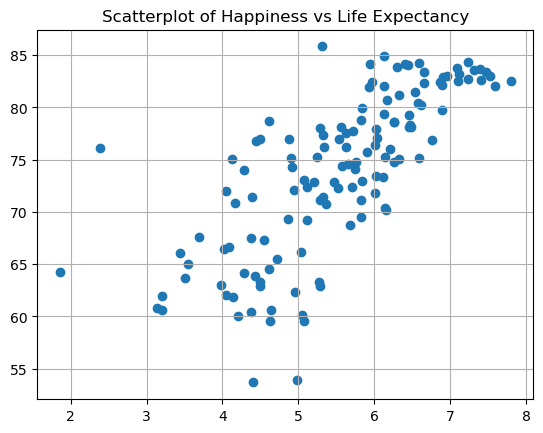

In [16]:
country_iso = []
for i in life_expectantcy_table[0]["Country"].values:
    country_name = i
    country_iso.append(country_to_iso(country_name))
    
country_iso_dict = {key: value for key, value in zip(country_iso, life_expectantcy_table[0]["Life Expectancy (both sexes)"])}

infla_dict = extract_corresponding_values_and_create_dict(iso_happy_dict, country_iso_dict)

plt.scatter(list(infla_dict.values()), list(infla_dict.keys()))
plt.grid(True)
plt.title('Scatterplot of Happiness vs Life Expectancy')
plt.show()

Idea: Maybe use these factors to do Natural Language Processing. Like we assign a number between 1-5 for every factor per country: like USA: Life Expectancy: 4, GDP per capita: 5, and Corruption: 2. Then we use these numbers to somehow to NLP where we can guess if a country is "good" or not based on these factors. 

In [17]:
import nltk
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    # Remove special characters, references, and citations
    text = re.sub(r'\[\d+\]', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_text = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_text)

# Function to scrape Wikipedia page content using BeautifulSoup
def scrape_wikipedia(country):
    url = f"https://en.wikipedia.org/wiki/Human_rights_in_{country.replace(' ', '_')}"
    response = requests.get(url)
    time.sleep(0.05)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        paragraphs = soup.find_all('p')
        text = ' '.join([p.get_text() for p in paragraphs])
        return preprocess_text(text)
    else:
        return None

# List of top 5 happiest and least happiest countries
happiest_countries = ['Finland', 'Denmark', 'Iceland', 'Netherlands', 'Sweden']
least_happiest_countries = ['Afghanistan', 'Lebanon', 'Sierra Leone', 'Zimbabwe', 'the_Democratic_Republic_of_the_Congo']

# Scraping and preprocessing text content for happiest countries
happiest_texts = [scrape_wikipedia(country) for country in happiest_countries]
happiest_texts = [text for text in happiest_texts if text is not None]

# Scraping and preprocessing text content for least happiest countries
least_happiest_texts = [scrape_wikipedia(country) for country in least_happiest_countries]
least_happiest_texts = [text for text in least_happiest_texts if text is not None]

# Convert text to feature vectors using CountVectorizer
vectorizer = CountVectorizer()
X_happiest = vectorizer.fit_transform(happiest_texts)
X_least_happiest = vectorizer.transform(least_happiest_texts)

# Print feature names (words)
print("Feature names:")
print(vectorizer.get_feature_names_out())

# Print feature vectors for happiest countries
print("\nFeature vectors for happiest countries:")
print(X_happiest.toarray())

# Print feature vectors for least happiest countries
print("\nFeature vectors for least happiest countries:")
print(X_least_happiest.toarray())

Feature names:
['abides' 'able' 'abolished' ... 'yliopisto' 'yttrandefrihetsgrundlagen'
 'zealand']

Feature vectors for happiest countries:
[[0 0 1 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [1 1 2 ... 0 1 0]]

Feature vectors for least happiest countries:
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]]


In [18]:
# Function to get top N words from feature vectors
def get_top_words(feature_vectors, vectorizer, n=10):
    # Get the counts of each word in the vocabulary
    word_counts = np.array(feature_vectors.sum(axis=0)).flatten()
    # Get the indices of the top N words
    top_indices = word_counts.argsort()[-n:][::-1]
    # Get the feature names (words) from the vectorizer
    feature_names = vectorizer.get_feature_names_out()
    # Get the top N words
    top_words = [feature_names[i] for i in top_indices]
    return top_words

# Get top 10 words for happiest countries
top_happiest_words = get_top_words(X_happiest, vectorizer, n=20)
print("\nTop 10 words for happiest countries:")
print(top_happiest_words)

# Get top 10 words for least happiest countries
top_least_happiest_words = get_top_words(X_least_happiest, vectorizer, n=20)
print("\nTop 10 words for least happiest countries:")
print(top_least_happiest_words)


Top 10 words for happiest countries:
['rights', 'human', 'law', 'freedom', 'denmark', 'sweden', 'women', 'finland', 'european', 'international', 'government', 'iceland', 'right', 'convention', 'danish', 'constitution', 'icelandic', 'discrimination', 'report', 'also']

Top 10 words for least happiest countries:
['government', 'rights', 'security', 'human', 'children', 'forces', 'law', 'groups', 'police', 'women', 'province', 'child', 'report', 'year', 'according', 'forced', 'president', 'country', 'however', 'reports']


In [19]:
# Function to get top N bigrams from feature vectors
def get_top_bigrams(feature_vectors, vectorizer, n=10):
    # Get the counts of each bigram in the vocabulary
    bigram_counts = np.array(feature_vectors.sum(axis=0)).flatten()
    # Get the indices of the top N bigrams
    top_indices = bigram_counts.argsort()[-n:][::-1]
    # Get the feature names (bigrams) from the vectorizer
    feature_names = vectorizer.get_feature_names_out()
    # Get the top N bigrams
    top_bigrams = [feature_names[i] for i in top_indices]
    return top_bigrams

# Function to generate bigrams
def generate_bigrams(text):
    tokens = word_tokenize(text)
    bigrams = [f"{tokens[i]}_{tokens[i+1]}" for i in range(len(tokens)-1)]
    return ' '.join(bigrams)

# Preprocess text and generate bigrams
happiest_texts_bigrams = [generate_bigrams(text) for text in happiest_texts]
least_happiest_texts_bigrams = [generate_bigrams(text) for text in least_happiest_texts]

# Convert text to feature vectors using CountVectorizer
vectorizer_bigrams = CountVectorizer()
X_happiest_bigrams = vectorizer_bigrams.fit_transform(happiest_texts_bigrams)
X_least_happiest_bigrams = vectorizer_bigrams.transform(least_happiest_texts_bigrams)

# Get top 10 bigrams for happiest countries
top_happiest_bigrams = get_top_bigrams(X_happiest_bigrams, vectorizer_bigrams, n=20)
print("\nTop 10 bigrams for happiest countries:")
print(top_happiest_bigrams)

# Get top 10 bigrams for least happiest countries
top_least_happiest_bigrams = get_top_bigrams(X_least_happiest_bigrams, vectorizer_bigrams, n=20)
print("\nTop 10 bigrams for least happiest countries:")
print(top_least_happiest_bigrams)


Top 10 bigrams for happiest countries:
['human_rights', 'european_convention', 'convention_human', 'freedom_speech', 'freedom_press', 'racial_discrimination', 'amnesty_international', 'icelandic_law', 'united_nations', 'asylum_seekers', 'freedom_expression', 'freedom_religion', 'saudi_arabia', 'rights_european', 'sexual_violence', 'court_human', 'declaration_human', 'european_union', 'universal_declaration', 'european_court']

Top 10 bigrams for least happiest countries:
['human_rights', 'security_forces', 'amnesty_international', 'sexual_violence', 'rights_abuses', 'men_women', 'rights_violations', 'law_prohibits', 'supreme_court', 'political_parties', 'rights_commission', 'united_nations', 'press_freedom', 'public_order', 'freedom_house', 'state_department', 'us_state', 'constitution_provides', 'pretrial_detention', 'international_human']


# Dynamic Graph of GDP per Capita vs Happiness Report (2015 - 2023)
https://countryeconomy.com/demography/world-happiness-index?year=2021

In [58]:
dfs = []

for year in range(2015, 2024):
    url = f"https://countryeconomy.com/demography/world-happiness-index?year={year}"
    
    test = pd.read_html(url)
    time.sleep(0.05)
    df = test[0]
    df['Year'] = year
    
    df['Countries'] = df['Countries'].apply(lambda x: re.sub(r'[^a-zA-Z ]', '', x))
    df['World Happiness Ranking'] = df['World Happiness Ranking'].apply(lambda x: x.replace('º', ''))
    df.set_index('World Happiness Ranking', inplace=True)
    df.index = pd.to_numeric(df.index)
    df.sort_index(inplace=True, ascending=True)
    
    df.dropna(axis=1, inplace=True)
    dfs.append(df)

massive_df = pd.concat(dfs)

In [46]:
gdp_p_capita['NGDPDPC']["HKG"]

{'2015': 42325.352,
 '2016': 43488.204,
 '2017': 46025.665,
 '2018': 48310.038,
 '2019': 48277.982,
 '2020': 46446.056,
 '2021': 49842.466,
 '2022': 48154.404,
 '2023': 51168.046}

In [59]:
gdp_p_capita = retrieve_data(["NGDPDPC"], "2015,2016,2017,2018,2019,2020,2021,2022,2023")
massive_df = massive_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    
gdp_capita_iso_list = []
for i in massive_df["Countries"].values:
    country_name = i
    gdp_capita_iso_list.append(country_to_iso(country_name))
    
massive_df["Countries"] = gdp_capita_iso_list

gdp_per_capita_values = []
for iso, year in zip(massive_df["Countries"].values, massive_df["Year"].values):
    year = str(year)
    if iso in gdp_p_capita['NGDPDPC'].keys() and year in gdp_p_capita['NGDPDPC'][iso]:
        gdp_per_capita_value = gdp_p_capita['NGDPDPC'][iso][year]
    else:
        gdp_per_capita_value = None
    gdp_per_capita_values.append(gdp_per_capita_value)
    
massive_df['GDP Per Capita'] = gdp_per_capita_values
massive_df = massive_df[massive_df['GDP Per Capita'].notna()]
massive_df = massive_df.drop(columns=['Ch.'])
massive_df

,Countries,World Happiness Index,Year,GDP Per Capita
World Happiness Ranking,,,,
1,CHE,7.587,2015,84230.676
2,ISL,7.561,2015,53227.627
3,DNK,7.527,2015,53478.495
4,NOR,7.522,2015,74568.136
5,CAN,7.427,2015,43626.470
...,...,...,...,...
131,MWI,3.495,2023,579.701
132,BWA,3.435,2023,7758.371
133,COD,3.207,2023,675.477


In [65]:
import bokeh.io
import bokeh.models
bokeh.io.output_notebook()
from bokeh.plotting import figure, show

gdp_df = massive_df.copy()

start = gdp_df["Year"].min()
end = gdp_df["Year"].max()
slider = bokeh.models.Slider(start=start, end=end, step=1, value=start)
years = gdp_df["Year"].unique()

p = figure(
    title=str(start),
    x_range = (2,8),
    y_range = (0,140000),
    tooltips=[("Country", "@{Countries}"),("Happiness Score", "@{World Happiness Index}"), ("GDP Per Capita", "@{GDP Per Capita}")],  # Add tooltips for hover
    
)
p.xaxis.axis_label = "Happiness Score"
p.yaxis.axis_label = "GDP Per Capita"

gdp_df.reset_index(inplace=True)
gdp_df["Year"] = gdp_df["Year"].astype(str)
source = bokeh.models.ColumnDataSource(gdp_df)
view = bokeh.models.CDSView(filter = bokeh.models.GroupFilter(
    column_name = "Year", group = str(start)))

p.scatter(
    x="World Happiness Index",
    y="GDP Per Capita",
    source=source,
    view=view,
    fill_alpha=1
)

callback = bokeh.models.CustomJS(
    args={"source": source, "view": view, "figure": p, "years": years},
    code="""
    var value = cb_obj.value.toString();
    view.filters[0].group = value;
    figure.title.text = value;
    source.change.emit();
""")

slider.js_on_change("value", callback)
layout = bokeh.layouts.Column(slider, p)
show(layout)

Loading BokehJS ...

In [66]:
from bokeh.plotting import figure, show, output_file

# Assume you have already created your interactive plot 'p'

# Specify the output file name
output_file("interactive_plot.html")

# Show the plot (this will also save it to the specified file)
show(p)